# Cell Counting Method Based on Unsupervised Machine Learning and Neural Network

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage
from sklearn.cluster import DBSCAN

In [2]:
#functions
def gray(img):
    assert img.shape[-1] == 3, "Wrong color format"
    return img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114

def imageGradient(image):
    dx = np.zeros(image.shape)
    dy = np.zeros(image.shape)
    
    for i in range(image.shape[0]):
        dy[i] = ndimage.correlate(image[i],[-1,0,1],mode = 'nearest',output=np.float64)
    
    for j in range(image.shape[1]):
        dx[:,j] = ndimage.correlate(image[:,j],[-1,0,1],mode = 'nearest',output=np.float64)
    
    mag = np.zeros(image.shape)
    mag[:,:] = (dx[:,:]**2 + dy[:,:]**2)**0.5
    ori = np.zeros(image.shape)
    ori[:,:] = np.arctan(dx[:,:]/(dy[:,:]+1e-16))
    return (mag,ori)

def get_points(mag,threshold = 0.2):
    threshold = threshold * np.max(mag)
    points = np.where(mag > threshold)
    X = np.zeros((len(points[0]),2))
    X[:,0] = points[0]
    X[:,1] = points[1]
    return X

def plot_points(X,c = -1):
    ax = plt.gca() 
    ax.invert_yaxis()
    if type(c) is int:
        ax.scatter(X[:,1],X[:,0])
    else:
        ax.scatter(X[:,1],X[:,0],c=c)
    plt.title("Data points")
    plt.show()

def reduce_cluster(y_pred, threshold=0.5):
    total = y_pred[-1] + 1
    freq_dict = dict()
    for i in range(total):
        freq = np.sum(y_pred == i)
        freq_dict[i] = freq

    final = []
    mean = np.mean(list(freq_dict.values()))
    for k,v in freq_dict.items():
        if v < mean * threshold:
            continue
        final.append(k)
    return final

def visualize(raw,X,y,final):
    X_visualize = np.zeros(X.shape)
    for i in range(len(X)):
        if y[i] in final:
            X_visualize[i] = X[i]
    plt.imshow(raw,cmap=plt.cm.gray)
    plt.scatter(X_visualize[:,1],X_visualize[:,0],c=y,alpha=1)
    plt.show()


## 1. Import raw image

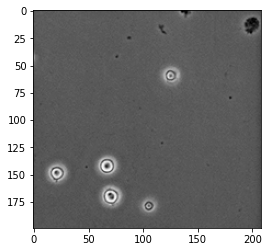

In [3]:
raw = plt.imread("sample.png")
raw = gray(raw)
plt.imshow(raw,cmap=plt.cm.gray)
plt.show()

## 2. Detect edges

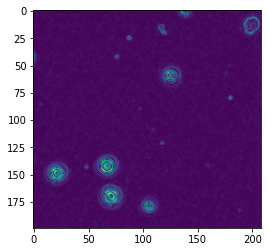

In [4]:
mag,ori = imageGradient(raw)
plt.imshow(mag)
plt.show()

## 3. Pick up points

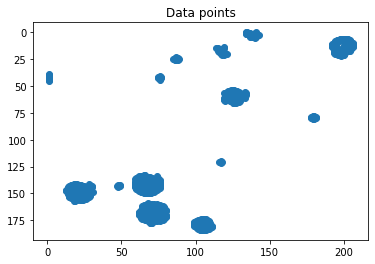

In [5]:
X = get_points(mag,0.2)
plot_points(X)

## 4. DBSCAN

In [6]:
y = DBSCAN(eps = 5, min_samples = 5).fit_predict(X)

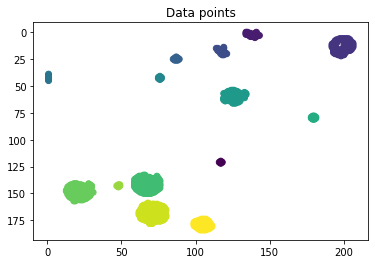

In [7]:
plot_points(X,y)

## 5. Reduce noise

In [8]:
final = reduce_cluster(y,0.6)

### Gross result is

In [9]:
len(final)

6

## 6. Cluster Visualize

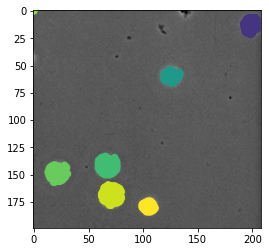

In [10]:
visualize(raw,X,y,final)

## 7. Sampling for CNN

In [11]:
def get_centers(X,y,final):
    centers = np.zeros((len(final),2))
    for i in range(len(X)):
        if not y[i] in final:
            continue
        centers[np.where(final == y[i])[0][0]] += X[i]
    for i in range(len(centers)):
        centers[i] = centers[i]/np.sum(y==final[i])
    return centers

In [12]:
def sampling(raw,centers,radius = 10):
    sample = np.zeros((len(centers),1,2*radius,2*radius))
    raw = np.pad(raw,((radius,radius),(radius,radius)),"maximum")
    for i in range(len(centers)):
        x,y = int(centers[i,0]),int(centers[i,1])
        sample[i][0] = raw[x:x+2*radius,y:y+2*radius]
    return sample

In [13]:
centers = get_centers(X,y,final)
sample = sampling(raw,centers,14)

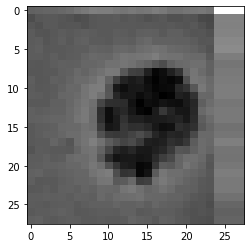

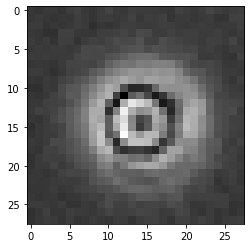

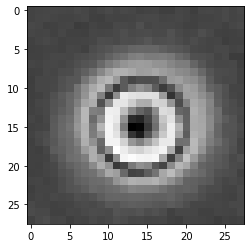

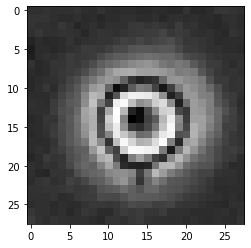

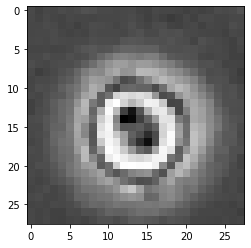

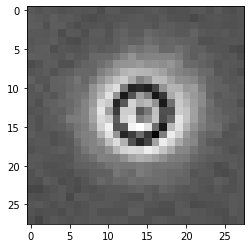

In [14]:
for img in sample:
    plt.imshow(img[0],cmap=plt.cm.gray)
    plt.show()

## 8. Fast train CNN

In [15]:
#sample from other image
from skimage import transform,data
target = gray(plt.imread("target.png"))
noise = gray(plt.imread("noise.png")[:,:,:-1])
target = transform.resize(target, (28, 28))
noise = transform.resize(noise, (28, 28))

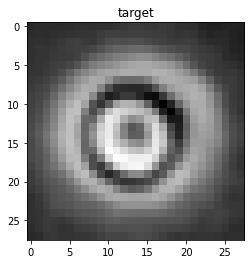

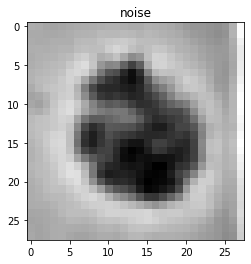

In [16]:
plt.imshow(target,cmap=plt.cm.gray)
plt.title("target")
plt.show()
plt.imshow(noise,cmap=plt.cm.gray)
plt.title("noise")
plt.show()

In [17]:
target = np.expand_dims(target,0)
target = np.expand_dims(target,0)
noise = np.expand_dims(noise,0)
noise = np.expand_dims(noise,0)
train = [target,noise]
label = [[0],[1]]

In [18]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        #128,128
        self.conv1 = nn.Conv2d(1,6,kernel_size=5,padding=2)
        #124,124
        self.conv2 = nn.Conv2d(6,16,kernel_size=5)
        #58,58
        self.conv3 = nn.Conv2d(16,120,kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120,84)
        self.fc2 = nn.Linear(84,2)
        self.logsoftmax = nn.LogSoftmax()
        
    def forward(self,x):
        in_size = x.size(0)
        out = self.relu(self.mp(self.conv1(x)))
        out = self.relu(self.mp(self.conv2(out)))
        out = self.relu(self.conv3(out))
        out = out.view(in_size, -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return self.logsoftmax(out)

In [20]:
model = Model()
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=1e-2,momentum=0.5)

In [21]:
for r in range(100):
    for t in range(len(train)):
        data = Variable(torch.Tensor(train[t]))
        pred = model(data)
        target = Variable(torch.LongTensor(label[t]))
        loss = loss_fn(pred,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

<ipython-input-19-4e1e2a3f8cfe>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(out)


## 9. CNN match

In [22]:
predict = model(torch.from_numpy(sample).float()).data.max(1, keepdim=True)[1]

<ipython-input-19-4e1e2a3f8cfe>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.logsoftmax(out)


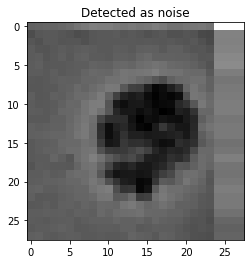

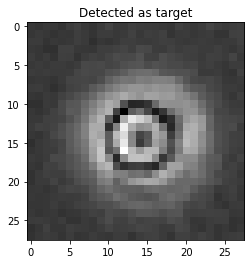

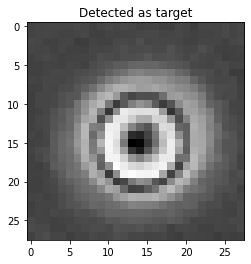

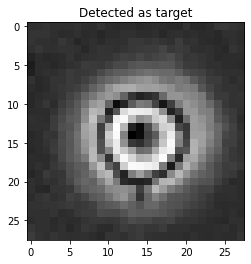

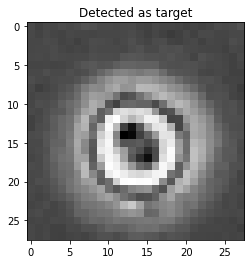

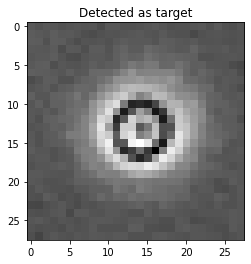

In [23]:
for i in range(len(sample)):
    plt.imshow(sample[i][0],cmap=plt.cm.gray)
    if int(predict[i]) == 0:
        plt.title("Detected as target")
    else:
        plt.title("Detected as noise")
    plt.show()

## Visualize and conclusion

In [24]:
res = []
for i in range(len(predict)):
    if int(predict[i]) == 1:
        continue
    res.append(final[i])

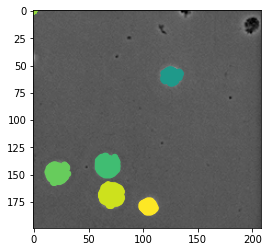

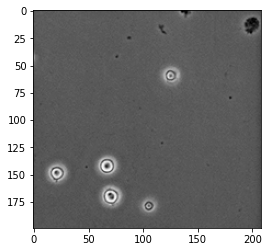

In [25]:
visualize(raw,X,y,res)
plt.imshow(raw,cmap=plt.cm.gray)
plt.show()

As we can see, all cells are detected and noise are removed

The final result is

In [26]:
len(res)

5

There are 5 cells on the image